In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(sys.path[0])))

# import matplotlib.pyplot as plt
import numpy as np
# import umap
import pandas as pd
from datasets import Dataset
import seaborn as sns
import json

from src.paths import get_project_root, outputp
# from src.reporting import extract_orders_from_sns

sns.set_style("whitegrid")

from tqdm.notebook import tqdm
tqdm.pandas()

import wandb
from dotenv import load_dotenv
load_dotenv()

True

## Load data

In [2]:
wandb.login() # relies on WANDB_API_KEY env var
run = wandb.init(
    project="ea-forum-analysis", job_type="visualization", dir=get_project_root()
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vpetukhov. Use `wandb login --relogin` to force relogin


wandb: ERROR Failed to sample metric: Not Supported


In [3]:
art = run.use_artifact("sbert_emb_data:all-mpnet-base-v2")
art.download()
data = pd.read_pickle(art.file())
# data = pd.read_pickle(datap("sbert_emb_data.pkl"))
posts = Dataset.load_from_disk(run.use_artifact("posts_raw:latest").download()).to_pandas()
posts = posts.set_index('pageUrl').loc[data['art_df'].pageUrl].reset_index().set_index('_id')

comments = Dataset.load_from_disk(run.use_artifact("comments_raw:latest").download()).to_pandas().set_index('_id')
users = Dataset.load_from_disk(run.use_artifact("users_raw:latest").download()).to_pandas().set_index('_id')

wandb: ERROR Failed to serialize metric: division by zero
wandb: Downloading large artifact sbert_emb_data:all-mpnet-base-v2, 76.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0
wandb: Downloading large artifact posts_raw:latest, 272.30MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0
wandb: Downloading large artifact comments_raw:latest, 209.93MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0
wandb:   3 of 3 files downloaded.  


## Match clusters and topics

In [4]:
clusts = data['art_df'].clust1.values
tags = posts.tags.map(lambda x: ['<EMPTY>'] if len(x) == 0 else x)
tags_per_clust = tags.groupby(clusts).apply(lambda x: x.explode().value_counts())
tags_per_clust = tags_per_clust.unstack().fillna(0)
tags_per_clust = tags_per_clust.iloc[:,tags_per_clust.sum().values > 50]

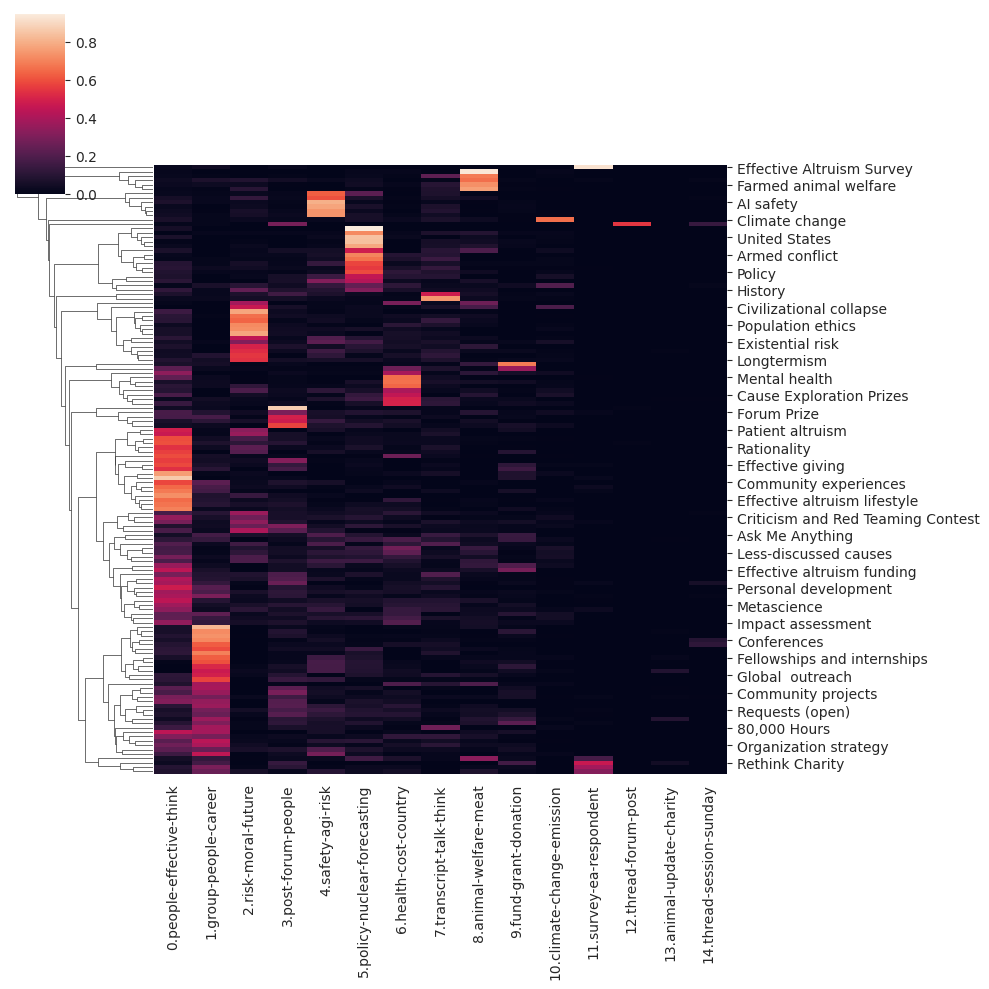

In [5]:
p_df = (tags_per_clust / tags_per_clust.sum()).T
p_df = p_df.loc[:,sorted(p_df.columns, key=lambda x: int(x.split('.')[0]))]
# p_df /= p_df.max()
cmap = sns.clustermap(p_df, col_cluster=False)
# col_ord, row_ord = extract_orders_from_sns(cmap)
row_ord = cmap.dendrogram_row.reordered_ind
cmap

In [6]:
js_df = p_df.iloc[row_ord,:].stack().reset_index().rename(columns={'level_0': 'tag', 'level_1': 'clust', 0: 'score'})
js_df['tag'], tag_levels = pd.factorize(js_df.tag)
js_df['clust'], clust_levels = pd.factorize(js_df.clust)
js_df['score'] = np.round(js_df.score, 3)

n_posts_per_clust = pd.value_counts(clusts)

In [7]:
clust_per_tag = tags_per_clust.idxmax()
n_tags_per_clust = pd.Series(clust_per_tag.index.groupby(clust_per_tag.values)).\
    map(len).reindex(n_posts_per_clust.index).fillna(0)

In [8]:
clust_info_json = {
    'tag_coocs': {
        'coocs': list(js_df.T.to_dict().values()),
        'tag_levels': list(tag_levels),
        'clust_levels': list(clust_levels)
    },
    'bar_info': {
        'num_posts': [int(v) for v in n_posts_per_clust],
        'num_tags': [int(v) for v in n_tags_per_clust],
        'clusters': list(n_posts_per_clust.index)
    }
}

with open(outputp('clust_info.json'), 'w') as f:
    json.dump(clust_info_json, f)

## Match clusters and users

In [9]:
from src.parsing import estimate_posts_per_user, estimate_relevant_posts_per_user
from pandas import Series

In [10]:
users['posts'] = estimate_posts_per_user(posts).reindex(users.index).map(lambda x: x if not isinstance(x, float) else [])
relevant_posts_per_user = estimate_relevant_posts_per_user(comments, users)

In [12]:
users.shape

(24903, 10)

In [11]:
relevant_posts_per_user

userId
242hgJ5zMvMT9vP9u               [3QhcSxHTz2F7xxXdY, QwsXNyujA7opwwhyW]
24EvwrPDnw3tJTpTH                                  [u5JesqQ3jdLENXBtB]
24kHTY5tmtbKG96dp                                  x6xrDrwiEKzfgks]
24oT6LSKevMDuvFbs               [Rn6wgWHmcnw8HTR32, Zzgcy7iRiPEA4ausW]
25DEBnp7Yjx8PkdcY    [R4Ee5LmEXDdwPEaAx, nSwaDrHunt3ohh9Et, me9FSqx...
                                           ...                        
zySsuFqHjYh86nYmP                                  [Pq9GRnyAbNLC4TPkW]
zyhDoYFjLXHRiWot9                                  [B3fYvmwJLRiDeM6Cd]
zymhTtssCo6cvPYQE               [wwW4u4sXbP8YbfBts, 2BEecjksNZNHQmdyM]
zz92GfoPPa7Y29k8u    [qrBq2v44Pyf3KgqmH, 9Xd63DYDbmd5K4dWw, X3XZbt3...
zzFLCMosqDyFzvMxB                                  [LpCewmJgosEaz7ZkW]
Length: 5394, dtype: object

## Finish

In [190]:
run.finish()